![test](https://storage.googleapis.com/kagglesdsdata/datasets/524341/962346/Group.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1583153167&Signature=i%2F6udkh5Z6NJb4cUCld04jsFsOZX%2FVx9Z0aD0ofe4Wrm19qS5cOfPXc6qzJqG7ecIBWa9MNyjDjfuqdLqeTSlL%2Bli4QC4G%2FfAI5kX5FmjMRKkHYQp03jQjFVrRZGPLpHNNAi1C35eP8v5KOOt%2FKz1bN4D%2BskPNAXfLLuX9aHjaHdLXd6%2Bq00Xb49CB%2BPxILhWdN6CgFA9JCP7zNKJ4SFNkIZsaDM7Zn9%2BTqtIzs3TWTfrVBilEGYvI1yyRgE49O6tjJrXTc88cw1IHTG8bDkDqvFZpNLiBHzU59CS446aCvVUBdyBERld4K7I%2B3EpNitV6wBLYyjnFkBkHtfD1YDyA%3D%3D)

This notebook contains three parts:
1. Data cleaning
2. Training the corpus from scratch using [Byte Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding)(bpe) method. Training a customized corpus is recommended, particularly when your texts belong to low-resource language or if you want to extract information from a specialized field such as clinical texts. After that, I trained the data using the [LSTM ](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)model. 
3. Training the corpus from scratch using the [Transformer BertWordpiece ](https://huggingface.co/transformers/model_doc/bert.html)method. Then I trained the data using the KerasBert model. 


**1. Cleaning dataset**

**1.1 Importing libraries and loading data**

In [ ]:

import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import emoji
import os
import time
import sys
import fasttext
import re
import nltk 
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
tf.keras.backend.clear_session()

import itertools
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#load data 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train.head()

In [ ]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test.head()

In [ ]:
train=train[['text','target']]
#null_data = train[train.isnull().any(axis=1)] there is no null value in test set after removing the id, keyword, location column
test=test[['id','text']]

In [ ]:
# check class distribution in train dataset
from scipy import stats
train.groupby(['target']).size()

In [ ]:
colors = list('rgb') #rgbkm
count_classes = pd.value_counts(train['target'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color=colors, figsize=(6,4))
plt.title("Class Distribution")
plt.xlabel("class")
plt.ylabel("Count");

In [ ]:
train.head()
train['text'].head()

**1.2 Data preprocessing**

In [ ]:
#import contractions list and remove it in the next step
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [ ]:
def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [ ]:
train['text']=train['text'].apply(remove_contractions)
train.tail()

In [ ]:
test['text']=test['text'].apply(remove_contractions)
len(test['text'])

In [ ]:
# clean dataset
def clean_dataset(text):
    # To lowercase
    text = text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Insert space between words and punctuation marks
    text = re.sub(r'([\w\d]+)([^\w\d ]+)', '\1 \2',text)
    text = re.sub(r'([^\w\d ]+)([\w\d]+)', '\1 \2',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove punctuation
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [ ]:
train['text'] =train['text'].apply(clean_dataset)
train.tail()

In [ ]:
test['text'] =test['text'].apply(clean_dataset)

In [ ]:
#remove stop word i.e. the most frequently appeared words 
# I ended up with building my own stop word lists because NLTP simply removed all negation words which totally changed the meaning of the sentence. 
myOwnStopList=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']

In [ ]:
#stop = stopwords.words('english')
#stop+=['get','got','getting','one','two','would','still','could','going']#customized stop word list
#stop = [e for e in stop if e not in ("n't", "not", "no")]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.

train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))
train.head()

In [ ]:
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))
pred=test['text']

**1.3 Visualizing dataset** 

In [ ]:
# most common words in twitter dataset 
all_texts = []
for line in list(train['text']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_texts)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_texts).values(), reverse=True)

In [ ]:
# create a word frequency dictionary
wordfreq = Counter(all_texts)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(all_texts[:30])

**1.4 Collecting texts for training corpus**

In [ ]:
toBeCleanedNew='[%s]' % ' '.join(map(str, all_texts))#remove all the quation marks and commas. 
#print(toBeCleanedNew)

In [ ]:
len(wordfreq)#the whole vocabulary size in train dataset

In this step, we are going to train the cleaned corpus (only training dataset) using the SentencePieceBPE model under the Huggingface library. Note: sometimes I got run-time errors even without changing my code. I am not sure; however, this is caused by huggingface or Kaggle. Either way, I found that by turning on/off the accelerator in the settings could solve the problem.  Each user could enjoy 30 hours per week (GPU/TPU) running time for free.

In [ ]:
#You need to install version==0.4.2 to run hugging face tokenizer on kaggle
!pip --no-cache-dir install tokenizers==0.4.2 #you get only a warning, just ignore it

**2. LSTM model (baseline)**

**2.1 Traing corpus using sentencepiece(BPE) method**

In [ ]:
#!pip install tokenizers #hugging face tokenizer
from tokenizers import (ByteLevelBPETokenizer,
                            CharBPETokenizer,
                            SentencePieceBPETokenizer,
                            BertWordPieceTokenizer)
tokenizer = SentencePieceBPETokenizer()
#Kaggle has a restriction to write file directly to the server, I download the cleaned corpus and uploaded it back.
path="../input/tobetrainedtxt/tobeTrained.txt"
#set vocab_size to 15000 as the len(train_set)was something like 12500 
tokenizer.train(files=path, vocab_size=15_000, min_frequency=2, special_tokens=[
   "<pad>",
   "<s>",
   "</s>",
   "<unk>",
   "<mask>",
])


In [ ]:
# Now I got my trained corpus and it saved to my working directory.
tokenizer.save(".", "/kaggle/working/tokenedText")

In [ ]:
#let's try to tokenize the first sentence
output = tokenizer.encode("deeds reason earthquake may allah forgive")
#print(output)
print(output.ids,output.tokens, output.offsets)

In [ ]:
#convert it back :)
decode=tokenizer.decode([119, 2281, 1940, 1002, 352, 3542, 9179])
print(decode)

In [ ]:
# As we don't have label for test dataset, I will split train dataset as trainsub and testsub dataset.
from sklearn.model_selection import train_test_split
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(
  train['text'],train['target'], test_size=0.2, random_state=42)

In [ ]:
X_subtrain.head()

In [ ]:
X_subtest.head()

In [ ]:
y_subtrain.head()

In [ ]:
# import trained corpus to tokenize our dataframe

from tokenizers.implementations import SentencePieceBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer =SentencePieceBPETokenizer(
    '/kaggle/working/tokenedText-vocab.json',
    '/kaggle/working/tokenedText-merges.txt', 
)
tokenizer._tokenizer.post_processor = BertProcessing(
   ("</s>", tokenizer.token_to_id("</s>")),
  ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

X_subtrain_tokened=X_subtrain.apply(lambda x:tokenizer.encode(x).ids)
X_subtrain_tokened.head()

In [ ]:
X_subtest_tokened=X_subtest.apply(lambda x:tokenizer.encode(x).ids)
X_subtest_tokened.head()

In [ ]:
y_subtrain.head()

In [ ]:
y_subtest.head()

In [ ]:
# the original test dataset (without label)
test["Tokened_Text"]=test["text"].apply(lambda x:tokenizer.encode(x).ids)
test.head()

In [ ]:
#check Vocabulary (VOCAB_SIZE) in test dataset
from collections import Counter
subtrain_tokened=[]
for i in X_subtrain_tokened:
    subtrain_tokened+=i
print("Total amount of tokens in train dataset is:", len(subtrain_tokened))
distinct_list= (Counter(subtrain_tokened).keys())
print("The vocabulary size in subtrain dataset is :",len(distinct_list))

In [ ]:
#print(distinct_list)
print(max(distinct_list))

In [ ]:
#check Vocabulary (VOCAB_SIZE) in test dataset
subtest_tokened=[]
for i in X_subtest_tokened:
    subtest_tokened+=i
print("Total amount of tokens in train dataset is:", len(subtest_tokened))
distinct_list_2= (Counter(subtest_tokened).keys())
print("The vocabulary size in subtrain dataset is :",len(distinct_list_2))

In [ ]:
# length distribution in tokened subtrain dataset
subtrain_length_dist=[]
i=0
for l in X_subtrain_tokened:
    subtrain_length_dist+=[len(l)]
y = np.array(subtrain_length_dist)
sns.distplot(y);

In [ ]:
# length distribution in tokened subtest dataset
subtest_length_dist=[]
i=0
for l in X_subtest_tokened:
    subtest_length_dist+=[len(l)]
y = np.array(subtest_length_dist)
sns.distplot(y);

In [ ]:
X_subtrain.head()
X_subtrain_tokened.head()

**2.2 Splitting train dataset into subtrain and subtest. Training data with LSTM model**

In [ ]:
import keras
max_len=30
x_train = keras.preprocessing.sequence.pad_sequences(X_subtrain_tokened, maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(X_subtest_tokened, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

In [ ]:
import tensorflow as tf
embedding_dim=128
vocab_size=9940
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()#

In [ ]:
y_train=y_subtrain
y_test=y_subtest

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import datetime
from tensorflow.python.keras.callbacks import TensorBoard

logs_base_dir = "./logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)
history=model.fit(x_train, y_train,
          batch_size=12,
          epochs=20,
          validation_data=[x_test, y_test]) 

In [ ]:
submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
test=keras.preprocessing.sequence.pad_sequences(test['Tokened_Text'], maxlen=max_len)
test.shape

**2.3 Predicting result**

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
submission=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pre})
submission.to_csv('submission.csv',index=False)

In [ ]:
submission.head()

**3. BERT model**

The following picture illustrates how to implement the tokenization process in Bert model. 

![process](http://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png)
 [source](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

**3.1 Training corpus using BertWordPieceTokenizer method**


In [ ]:
#!pip install tokenizers #hugging face tokenizer
from tokenizers import (ByteLevelBPETokenizer,
                            CharBPETokenizer,
                            SentencePieceBPETokenizer,
                            BertWordPieceTokenizer)
tokenizer = BertWordPieceTokenizer()

path="../input/forbert/tobeTrainedForBert.txt"
#set vocab_size to 15000 as the len(train_set)was something like 12500 
tokenizer.train(files=path, vocab_size=15_000, min_frequency=2)
#tokenizer.train(files=path, vocab_size=15_000, min_frequency=2,special_tokens=[
   # "<s>",
    #"<pad>",
    #"</s>",
    #"<unk>",
    #"<mask>"
#])

In [ ]:
# Now I got my trained corpus and it saved to my working directory.
tokenizer.save(".", "/kaggle/working/newBert")

In [ ]:
#token.ids  PAD-->0, UNK-->1, CLS-->2 (start of sentence),SEP-->3 (end of sentence),MASK-->4
tokenizer = BertWordPieceTokenizer(
    "/kaggle/working/newBert-vocab.txt", 
     lowercase=True, 
   # unk_token="<unk>",
    #sep_token="</s>",
   # cls_token="<s>"
)
#tokenizer.add_special_tokens(["<pad>", "<mask>"])

In [ ]:
print(tokenizer)

In [ ]:
output = tokenizer.encode("Hello, y'all! 🙂 How are you  ?")
print(output.tokens)
print(output.ids)

In [ ]:
tokenizer.enable_truncation(max_length=30)

In [ ]:
outputLongerThan30=tokenizer.encode("BBC News is an operational business division of the British Broadcasting Corporation responsible for the gathering and broadcasting of news and current affairs. ")
print(outputLongerThan30.tokens)#cut off length > 30 parts =="and current affairs. "

In [ ]:
print(outputLongerThan30.ids)

In [ ]:
convertback=tokenizer.decode([2, 2884, 355, 634, 168, 3821, 87, 1177, 3577, 1050, 7393, 1103, 2135, 9171, 83, 2587, 4406, 151, 6960, 303, 1103, 21, 520, 83, 2875, 9171, 83, 7393, 355, 3])
print(convertback)

The BERT layer requires three input sequences:

* Token ids: for every token in the sentence. In my code, I call it input_ids.
* Mask ids : BERT replaces 15% of the words in each sequence with a mask token. The model then try to predict the original   value of the masked words, based on the context provided by the other, non-masked, words in the sequence. 
* Segment ids: 0 for one-sentence sequence, 1 for the second sentences in the sequence. In this experimental, we only have
  one sentence, so the sequence id is 0.


**3.2 Applying tokenization process**

In [ ]:
def bert_token(texts,max_len=128): 
    all_input_ids=[]
    all_mask_ids=[]
    all_seg_ids=[]
    for token in texts: 
    
        input_ids=tokenizer.encode(token).ids
        mask_ids = [1] * len(input_ids)
        seg_ids = [0] * len(input_ids)
        padding = [0] * (max_len - len(input_ids))
        input_ids += padding
        mask_ids += padding
        seg_ids += padding
        all_input_ids.append(input_ids)
        all_mask_ids.append(mask_ids)
        all_seg_ids.append(seg_ids)

    
    return np.array(all_input_ids), np.array(all_mask_ids), np.array(all_seg_ids)

In [ ]:
train_input=bert_token(X_subtrain,max_len=32)
test_input=bert_token(X_subtest,max_len=32)
pred=bert_token(pred,max_len=32)

**3.3 Building Bert model **

In [ ]:
def build_model(bert_layer, max_len=128):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    mask_ids = Input(shape=(max_len,), dtype=tf.int32, name="mask_ids")
    seg_ids = Input(shape=(max_len,), dtype=tf.int32, name="seg_ids")

    pooled_output, sequence_output = bert_layer([input_ids,mask_ids,  seg_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids,  mask_ids,  seg_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
model = build_model(bert_layer, max_len=32)
model.summary()

In [ ]:
#Can I use TensorBoard with Google Colab?
#Tensorboard: ValueError: Duplicate plugins for name projector #22676
logs_base_dir = "./logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
model.fit(
    train_input, 
    y_subtrain,
    callbacks=[tensorboard_callback],
    validation_data=(test_input, y_subtest),
    epochs=15,
    batch_size=12 # In this case, the accuracy rate will be improved if you reduce the batch_size e.g., from 32 to 12. 
)

**3.4 Predicting result**

In [ ]:
model.save('BertModel.h5')
pred = model.predict(pred)
model.load_weights('BertModel.h5')

In [ ]:
submission['target'] =pred.round().astype(int)
submission2=submission.to_csv('submission2.csv',index=False)

In [ ]:
#for some reason, the tensorboard does not show here. But if you run the code somewhere else e.g., Colab, then you can visualize
#learning rate and its architecture. 
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

It seems that I break the Bert performance record, but in the wrong direction. The accuracy rates in Bert model ranged from 0.55 to 0.70. The low accuracy rate might be caused by the small corpus size( less than 10,000 words) I trained. (ref [1](https://www.researchgate.net/post/What_is_the_minimum_corpus_size_for_keyword_and_collocate_testing) & [2](https://corpus.byu.edu/size.asp)) Please feel free to let me know your thoughts. 

The unique part of this notebook was the custom language models. Currently, the most common corpus for NLP projects is collected from social media or news in English. When you are able to build custom language models, you can go beyond those limits. In other words, you are free to do a study in any field in different languages (as long as you have enough data :D). For more details, please visit [Huggingface](https://huggingface.co/transformers/main_classes/tokenizer.html) website. 

Thanks for Kaggle offering us this learning opportunity. I completed this work in a hard way, but I 've managed seamlessly to connect those tokens to LSTM and Bert models. And I am happy with it. 

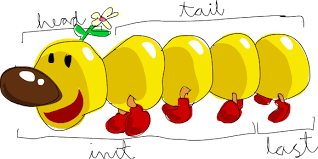